# Classification Project

In [6]:
# Required libraries
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

### Task 2

In [8]:
data = sio.loadmat("MNist_ttt4275/data_all.mat") # Load the data

# Extract the data
testv = data["testv"]
testlab = data["testlab"].flatten()
num_test = data["num_test"][0][0]

trainv = data["trainv"]
trainlab = data["trainlab"].flatten()
num_train = data["num_train"][0][0]

vec_size = data["vec_size"][0][0]

# Create vector consisting of test and train images
test_images = []
train_images = []

for i in range(num_test):
   test_images.append(testv[i, :].reshape((28,28)))
   
for i in range(num_train):
   train_images.append(trainv[i, :].reshape((28,28)))

test_images = np.array(test_images)
train_images = np.array(train_images)

### Necessarry functions

In [18]:
# Calculates error rate

def error_rate(predicted_labels, true_labels):
    error = 0
    for i in range(num_test):
        if predicted_labels[i] != true_labels[i]: error += 1 # Increment error for each misclassified image
    return error/num_test # Return the error rate as a percentage

In [14]:
# Confusion Matrix

def confusion_matrix_func(predicted_labels):
    predicted_labels = np.array(predicted_labels).flatten() # format predicted labels

    confusion_matrix = np.zeros((10, 10), dtype=int) # x represents the true label, y represents the predicted label
    missclassified_idx = []

    for i in range(num_test):
        confusion_matrix[testlab[i]][[predicted_labels[i]]] += 1 # Increment the confusion matrix for each image
        if testlab[i] != predicted_labels[i]: # If the image is misclassified, add it to the list
            missclassified_idx.append(i)

    print(np.array_str(confusion_matrix, precision=2, suppress_small=True))
    return confusion_matrix, missclassified_idx # Return the confusion matrix and the list of misclassified images

### Task 2.1 a)

In [ ]:
# Individual nearest Neighborhood classifier
# Not used in the final code, but can be used to test the classifier on a single image

def nnclassifier(new_image):
    nearest_class = trainlab[0]
    current_distance = np.linalg.norm(train_images[0] - new_image)
    for i in range(1, num_train): # Loop through all training images
        new_distance = np.linalg.norm(train_images[i] - new_image) # Calculate the distance between the new image and the training image
        if current_distance > new_distance: # If the new distance is smaller than the current distance, update the nearest class
            current_distance = new_distance # Update the current distance
            nearest_class = trainlab[i] # Update the nearest class
    return nearest_class

In [7]:
# Nearest Neighborhood Classifier using cdist
def nnclassifier():
    n_chunks = num_test//1000 # Number of chunks
    predicted_labels = []
    for i in range(n_chunks): # Loop through all chunks
        test_chunk = testv[1000*i: 1000*(i+1)] # Extract chunks
        distance_matrix = cdist(test_chunk, trainv, metric='euclidean') # Calculates the euclidean distance between each image in the test chunk and all the training images
        nearest_indices = np.argmin(distance_matrix, axis=1) # Finds the indices of the images that where closest for each image in the test chunk
        predicted_labels.extend(trainlab[nearest_indices]) # Finds the label of the image that was closest for each image in the test chunk
    return predicted_labels

predicted_labels = nnclassifier()


Confusion matrix

[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1129    3    0    1    1    1    0    0    0]
 [   7    6  992    5    1    0    2   16    3    0]
 [   0    1    2  970    1   19    0    7    7    3]
 [   0    7    0    0  944    0    3    5    1   22]
 [   1    1    0   12    2  860    5    1    6    4]
 [   4    2    0    0    3    5  944    0    0    0]
 [   0   14    6    2    4    0    0  992    0   10]
 [   6    1    3   14    5   13    3    4  920    5]
 [   2    5    1    6   10    5    1   11    1  967]]


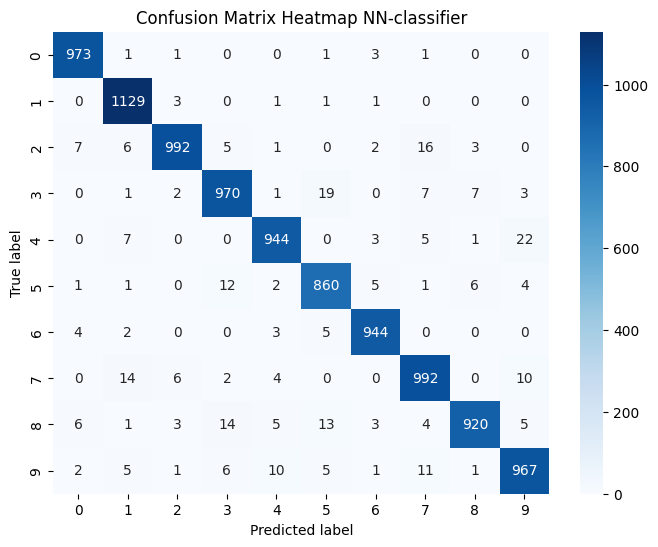

In [22]:
# Confusion Matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = confusion_matrix_func(predicted_labels)[0]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", square=False, xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix Heatmap NN-classifier")
# plt.savefig("Figure/confusion_matrix.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
error_rate(predicted_labels, testlab)

0.0309

### Task 2.1 b)
Plotting some misclassified images

Actual label is:  8
Predicted label is:  5


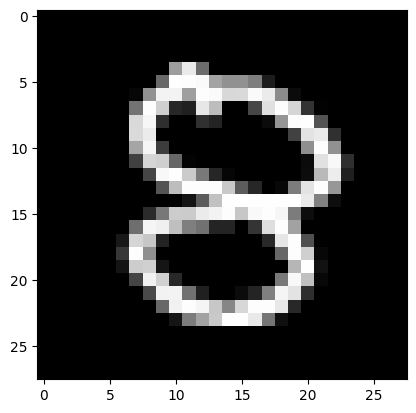

In [9]:
missclassified_idx = confusion_matrix_func(predicted_labels)[1]

def image_info(idx):
    print("Actual label is: ", testlab[idx])
    print("Predicted label is: ", predicted_labels[idx])
    # return plt.imshow(test_images[idx], cmap="gray")
    plt.imshow(test_images[idx], cmap="gray")
    plt.show()
    
image_info(missclassified_idx[3])
# plt.savefig("Figure/missclassified_8.pdf")


### Task 2.2 a)

### Clustering + NN

In [10]:
from sklearn.cluster import KMeans

M = 64 # Number of clusters per label
train_v = {} # Dictionary to store the images of each label
C = [] # List to store the cluster centers

# Creates a dictionary with the unique labels as keys and the corresponding images as values
for i in np.unique(trainlab): # For each unique label
    train_v[i] = trainv[trainlab == i] # Store all images with the same label at the same index

# KMeans clustering
for i in train_v.keys(): # For each label
    kmeans = KMeans(n_clusters=M, random_state=42) # Create 64 clusters
    _ = kmeans.fit_predict(train_v[i]) # Fit the model
    C.extend(kmeans.cluster_centers_) # Extranct cluster centers and ads them to C


Classifying the elements using clustering

In [ ]:
# Nearest Neighborhood Classifier using cdist
def nnclassifier_clustering():
    all_labels = np.concatenate([[i]*64 for i in range(10)])  # Assigns labels to the cluster centers
    predicted_labels = []

    n_chunks = num_test//1000 # Number of chunks
    for i in range(n_chunks): # Loop through all chunks
        test_chunk = testv[1000*i: 1000*(i+1)] # Extract chunks
        distance_matrix = cdist(test_chunk, C, metric='euclidean') # Calculates the euclidean distance between each image in the test chunk and all the cluster centers
        nearest_indices = np.argmin(distance_matrix, axis=1) # Finds the indices of closest cluster centers for each image in the test chunk
        predicted_labels.extend(all_labels[nearest_indices]) # Finds the label of the cluster that was closest for each image in the test chunk
        
    return predicted_labels

predicted_labels_clustering = nnclassifier_clustering()

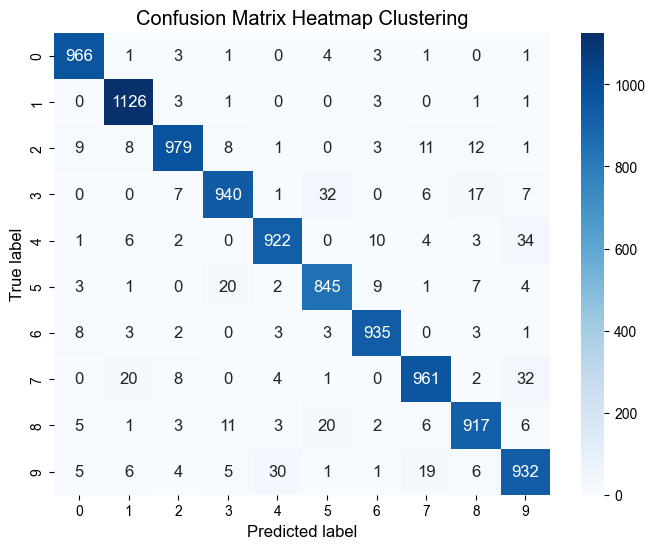

In [48]:
confusion_matrix = confusion_matrix_func(predicted_labels_clustering)[0]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", square=False, xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix Heatmap Clustering")
# plt.savefig("Figure/confusion_matrix_clustering.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [13]:
error_rate(predicted_labels_clustering, testlab)

0.0477

### KNN with K = 7

In [ ]:
# K - Nearest Neighborhood Classifier using cdist and K = 7
def KNN_classifier(k = 7):
    n_chunks = num_test//1000 # Find the number of chunks
    predicted_labels = [] # List to store the predicted labels

    for i in range(n_chunks): # For each chunk
        test_chunk = testv[1000*i: 1000*(i+1)] # Extract the chunk
        distance_matrix = cdist(test_chunk, trainv, metric='euclidean') # Calculates the euclidean distance between each image in the test chunk and all the training images
        k_nearest_indices = np.argpartition(distance_matrix, k)[:, :k] # returns the indices of the k closest images

        for test_idx in range(len(test_chunk)): # For each image in the test chunk
            neighbor_indices = k_nearest_indices[test_idx] # Get the indices of the k closest images
            neighbor_labels = trainlab[neighbor_indices] # Find the labels of the k closest images
            neighbor_distances = distance_matrix[test_idx][neighbor_indices] # Find the distances of the k closest images
            
            # Count how often each label appears
            label_counts = np.bincount(neighbor_labels, minlength=10)
            max_count = np.max(label_counts)

            # Find all labels that are tied for most frequent
            tied_labels = np.flatnonzero(label_counts == max_count) # returns a vector of the labels that are tied for most frequent

            if len(tied_labels) == 1: # If there is no tie, choose the most frequent label
                predicted_labels.append(tied_labels[0])
            else:
                # If there is a tie, choose the one with the smallest distance
                min_distance = np.inf
                closest_label = None
                for idx, label in enumerate(neighbor_labels):
                    # If a label is tied and its distance is smaller than the current minimum, update the closest label
                    if label in tied_labels and neighbor_distances[idx] < min_distance:
                        min_distance = neighbor_distances[idx]
                        closest_label = label
                predicted_labels.append(closest_label)

    return predicted_labels

predicted_labels_KNN = KNN_classifier()

[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [  11    7  988    2    1    0    2   17    4    0]
 [   0    3    2  972    1   13    1    8    6    4]
 [   1    7    0    0  944    0    5    2    1   22]
 [   5    0    0    6    2  868    4    1    2    4]
 [   6    3    0    0    3    2  944    0    0    0]
 [   0   24    3    0    1    0    0  990    0   10]
 [   6    3    4   12    6    9    3    5  920    6]
 [   5    6    3    6    7    4    1    9    2  966]]


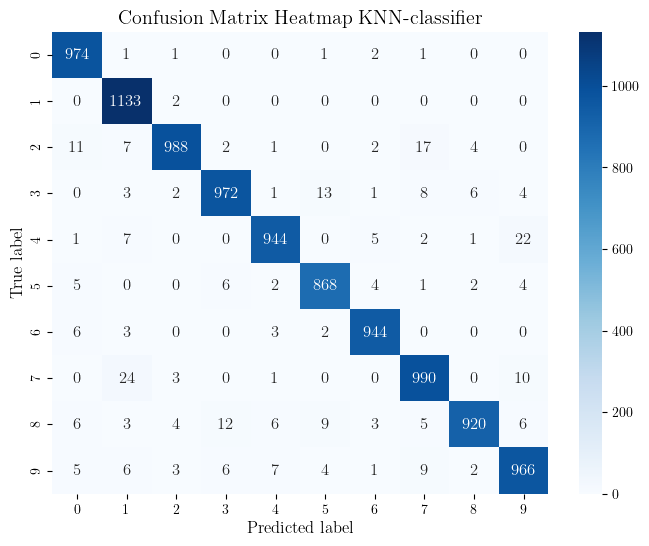

In [ ]:
import seaborn as sns

# Confusion Matrix
confusion_matrix = confusion_matrix_func(predicted_labels_KNN)[0]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", square=False, xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix Heatmap KNN-classifier")
# plt.savefig("Figures/confusion_matrix_KNN.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
error_rate(predicted_labels_KNN, testlab)

0.0301

### PCA plotting

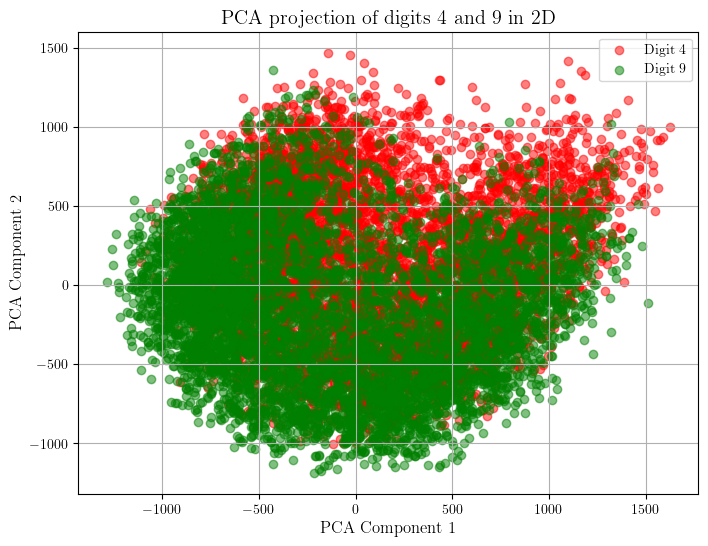

In [ ]:
from sklearn.decomposition import PCA

# Filter trainv for only digits 4 and 9
flag_4_9 = (trainlab == 4) | (trainlab == 9) # Returns a vector of True or False for each image
images_4_9 = trainv[flag_4_9] # Extract images of digits 4 and 9
labels_4_9 = trainlab[flag_4_9] # Extract labels of digits 4 and 9

# PCA
pca = PCA(n_components=2) # Create PCA object with 2 components
X_2D = pca.fit_transform(images_4_9) # Fit the PCA model to the data

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[labels_4_9 == 4, 0], X_2D[labels_4_9 == 4, 1], alpha=0.5, label = 'Digit 4', color = 'red')
plt.scatter(X_2D[labels_4_9 == 9, 0], X_2D[labels_4_9 == 9, 1], alpha=0.5, label = 'Digit 9', color = 'green')
plt.title("PCA projection of digits 4 and 9 in 2D")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
# plt.savefig('Figure/PCA_4_9.pdf')
plt.show()
